# Project Description

This file contains the implementation of the Bi-LSTM and Bi-LSTM-CNN models for sentiment analysis on the drugsComTraindataset. The main process in this file involves pre-processing the data, training the models, testing the models on the the same dataset, evaluating the model performance on the test data, generating training and validation curves, and plotting the confusion matrix.



In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
#from tensorflow.keras import layers
from keras import layers
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
from keras.models import Sequential
#from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

In [2]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('drugsComTrain_raw.csv')

In [4]:
df.shape

(161297, 7)

In [5]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
report=['condition','review']

In [7]:

df['report'] =df[report].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df

,uniqueID,drugName,condition,review,rating,date,usefulCount,report
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"Left Ventricular Dysfunction_""It has no side e..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"ADHD_""My son is halfway through his fourth wee..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"Birth Control_""I used to take another oral con..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"Birth Control_""This is my first time using any..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"Opiate Dependence_""Suboxone has completely tur..."
...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125,"Alcohol Dependence_""I wrote my first report in..."
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34,"Nausea/Vomiting_""I was given this in IV before..."
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35,"Rheumatoid Arthritis_""Limited improvement afte..."
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79,"Underactive Thyroid_""I&#039;ve been on thyroid..."


In [8]:

df_train = df.drop(['uniqueID','drugName','date','usefulCount','condition','review'],axis=1)
df_train .head(10)

,rating,report
0,9,"Left Ventricular Dysfunction_""It has no side e..."
1,8,"ADHD_""My son is halfway through his fourth wee..."
2,5,"Birth Control_""I used to take another oral con..."
3,8,"Birth Control_""This is my first time using any..."
4,9,"Opiate Dependence_""Suboxone has completely tur..."
5,2,"Benign Prostatic Hyperplasia_""2nd day on 5mg s..."
6,1,"Emergency Contraception_""He pulled out, but he..."
7,10,"Bipolar Disorde_""Abilify changed my life. Ther..."
8,1,"Epilepsy_"" I Ve had nothing but problems with..."
9,8,"Birth Control_""I had been on the pill for many..."


In [9]:
def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()
    
    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces 
    text = re.sub(r"\n", r" ", text)
        
    # Tokenize the sentence
    word_tokens = word_tokenize(text)
    
    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))
    
    # Specify the stop words list
    stop_words = stopwords.words('english')
    
    # Remove the stopwords and words containing less then 2 characters
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word not in stop_words)]
    
    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)
    
    return text

In [10]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [11]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [12]:
df_train['report'] = df_train['report'].apply(lambda x: clean_text(x))

In [13]:
df_train['rating']

0          9
1          8
2          5
3          8
4          9
          ..
161292    10
161293     1
161294     2
161295    10
161296     9
Name: rating, Length: 161297, dtype: int64

In [14]:
def map_rating_to_class(rating):
    if rating >= 7:
        return 'positive'
    elif rating <= 4:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create a new column 'rating_class' in the DataFrame
# Apply the function to create a new column 'class' in the DataFrame using .loc[row_indexer, col_indexer]
df_train.loc[:, 'rating'] = df_train['rating'].apply(map_rating_to_class)

#print(df.head(10))

In [15]:

df_train['rating'] 

0         positive
1         positive
2          neutral
3         positive
4         positive
            ...   
161292    positive
161293    negative
161294    negative
161295    positive
161296    positive
Name: rating, Length: 161297, dtype: object

In [16]:
Sentiment_train = df_train['rating']
Report_train = df_train['report']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Report_train, Sentiment_train, test_size=0.25)
#print("Training Data Input Shape: ", X_train.shape)
#print("Training Data Output Shape: ", y_train.shape)
#print("Testing Data Input Shape: ", X_test.shape)
#print("Testing Data Output Shape: ", y_test.shape)
#print("Training Data Input Shape: ", X_train)
#print("Training Data Output Shape: ", y_train)
#print("Testing Data Input Shape: ", X_test)
#print("Testing Data Output Shape: ", y_test)

In [18]:
from numpy import array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# One-Hot Encoding of Sentiment_Train
Sentiment_train = array(Sentiment_train)
# integer encode
label_encoder = LabelEncoder()
Sentiment_train_integer_encoded = label_encoder.fit_transform(Sentiment_train)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
Sentiment_train_integer_encoded = Sentiment_train_integer_encoded.reshape(len(Sentiment_train_integer_encoded), 1)
Sentiment_train_onehot_encoded = onehot_encoder.fit_transform(Sentiment_train_integer_encoded)
# One-Hot Encoding of Sentiment_Test
Sentiment_test = array( y_test)
# integer encode
label_encoder = LabelEncoder()
Sentiment_test_integer_encoded = label_encoder.fit_transform(y_test)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
Sentiment_test_integer_encoded = Sentiment_test_integer_encoded.reshape(len(Sentiment_test_integer_encoded), 1)
Sentiment_test_onehot_encoded = onehot_encoder.fit_transform(Sentiment_test_integer_encoded)
print("Sentiment_Train shape after one-hot encoding : ",Sentiment_train_onehot_encoded.shape,"  "
     ,"Sentiment_Test shape after one-hot encoding : ",Sentiment_test_onehot_encoded.shape,"\n")

Sentiment_Train shape after one-hot encoding :  (161297, 3)    Sentiment_Test shape after one-hot encoding :  (40325, 3) 



In [19]:
# Tokenize and Create Sequence For Train set
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(Report_train)
Report_train_sequences = tokenizer.texts_to_sequences(Report_train)
Report_train_padded = pad_sequences(Report_train_sequences, maxlen=100, padding='post', truncating='post')             # maxlen is the size of words in a review here it is 100
# Tokenize and Create Sequence For Test set
Report_test_sequences = tokenizer.texts_to_sequences(X_test)
Report_test_padded = pad_sequences(Report_test_sequences, maxlen=100, padding='post', truncating='post')
print("Report_Train shape after padding : ",Report_train_padded.shape,"  ","Report_Test shape after padding: ",Report_test_padded.shape)
Sentiment_labels = ['Negative', 'Neutral', 'Positive']    

Report_Train shape after padding :  (161297, 100)    Report_Test shape after padding:  (40325, 100)


In [20]:
vocab_size = len(tokenizer.index_word) + 1
vocab_size 

60563

In [51]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

# Bi-LSTM

In [23]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout
LSTM_model = Sequential()
sequence_len=100
LSTM_model.add(layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=sequence_len))
LSTM_model.add(SpatialDropout1D(0.3))
LSTM_model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
LSTM_model.add(Dense(1024, activation="relu"))
LSTM_model.add(Dropout(0.8))
LSTM_model.add(Dense(1024, activation="relu"))
LSTM_model.add(Dropout(0.8))
LSTM_model.add(Dense(3))
LSTM_model.add(Activation("softmax"))
LSTM_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(LSTM_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6056300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1024)              205824    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)             

In [62]:
history_LSTM = LSTM_model.fit(Report_train_padded,Sentiment_train_onehot_encoded, epochs=5, batch_size=64, validation_data=(Report_test_padded, Sentiment_test_onehot_encoded))



Epoch 1/5
2521/2521 [==============================] - 2983s 1s/step - loss: 0.6438 - accuracy: 0.7574 - val_loss: 0.5188 - val_accuracy: 0.8044
Epoch 2/5
2521/2521 [==============================] - 3218s 1s/step - loss: 0.5586 - accuracy: 0.7927 - val_loss: 0.4822 - val_accuracy: 0.8219
Epoch 3/5
2521/2521 [==============================] - 3253s 1s/step - loss: 0.5226 - accuracy: 0.8052 - val_loss: 0.4575 - val_accuracy: 0.8247
Epoch 4/5
2521/2521 [==============================] - 3444s 1s/step - loss: 0.4975 - accuracy: 0.8134 - val_loss: 0.4230 - val_accuracy: 0.8385
Epoch 5/5
2521/2521 [==============================] - 4457s 2s/step - loss: 0.4760 - accuracy: 0.8211 - val_loss: 0.3938 - val_accuracy: 0.8476


In [84]:
import time
import itertools
import warnings
from sklearn.metrics import confusion_matrix
# Model Evaluation on Test data
test_loss,test_acc = LSTM_model.evaluate(Report_test_padded, Sentiment_test_onehot_encoded)
print("\n Evaluated model accuracy on test data :",test_acc)
seconds= time.time()
time_stop = time.ctime(seconds)
print("\n","stop time:", time_stop,"\n")
# Predict the values from the Test dataset
Sentiment_pred = LSTM_model.predict(Report_test_padded)
# Convert predictions classes to one hot vectors
Sentiment_pred_classes = np.argmax(Sentiment_pred,axis = 1)
# computing the confusion matrix

1261/1261 [==============================] - 59s 47ms/step - loss: 0.3938 - accuracy: 0.8476

 Evaluated model accuracy on test data : 0.8475635647773743

 stop time: Wed May  3 23:55:31 2023 

1261/1261 [==============================] - 59s 47ms/step


In [85]:
confusion_mtx = confusion_matrix(Sentiment_test_integer_encoded, Sentiment_pred_classes)
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

In [86]:
#Printing Classification Report for Sentiment
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(Sentiment_test_integer_encoded, Sentiment_pred_classes, target_names = Sentiment_labels))
accuracy = accuracy_score(Sentiment_test_integer_encoded, Sentiment_pred_classes)
print('Accuracy: %f' % accuracy)
cohen_score = cohen_kappa_score(Sentiment_test_integer_encoded, Sentiment_pred_classes)
print('Cohen_score: %f' % cohen_score)

              precision    recall  f1-score   support

    Negative       0.78      0.84      0.81     10055
     Neutral       0.00      0.00      0.00      3543
    Positive       0.87      0.96      0.92     26727

    accuracy                           0.85     40325
   macro avg       0.55      0.60      0.57     40325
weighted avg       0.77      0.85      0.81     40325

Accuracy: 0.847564
Cohen_score: 0.660347


C:\Users\Sena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


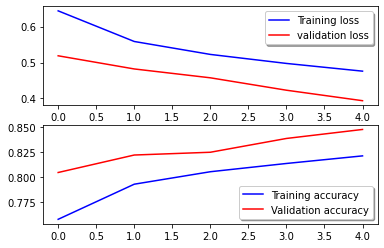

In [65]:

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history_LSTM .history['loss'], color='b', label="Training loss")
ax[0].plot(history_LSTM .history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history_LSTM .history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_LSTM .history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

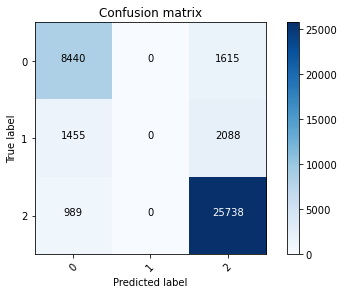

In [66]:
# Defining function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

# Bi-LSTM_CNN

In [32]:
# Build the CNN-LSTM model
sequence_len=100
modelCNN_LSTM = Sequential()
modelCNN_LSTM.add(layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=sequence_len ))
modelCNN_LSTM.add(Conv1D(64, 5, activation='relu'))
modelCNN_LSTM.add(MaxPooling1D(pool_size=4))
modelCNN_LSTM.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.3)))
modelCNN_LSTM.add(Dense(len(label_encoder.classes_), activation='softmax'))
# Compile the model
modelCNN_LSTM.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(modelCNN_LSTM.summary())
# Train the model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          6056300   
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,154,799
Trainable params: 6,154,799
No

In [33]:
history_LSTM_CNN= modelCNN_LSTM.fit(Report_train_padded,Sentiment_train_onehot_encoded, epochs=5, batch_size=128, validation_data=(Report_test_padded, Sentiment_test_onehot_encoded))



Epoch 1/5
1261/1261 [==============================] - 283s 215ms/step - loss: 0.5896 - accuracy: 0.7728 - val_loss: 0.4636 - val_accuracy: 0.8269
Epoch 2/5
1261/1261 [==============================] - 271s 215ms/step - loss: 0.4529 - accuracy: 0.8282 - val_loss: 0.3331 - val_accuracy: 0.8755
Epoch 3/5
1261/1261 [==============================] - 264s 210ms/step - loss: 0.3349 - accuracy: 0.8749 - val_loss: 0.2246 - val_accuracy: 0.9309
Epoch 4/5
1261/1261 [==============================] - 266s 211ms/step - loss: 0.2267 - accuracy: 0.9184 - val_loss: 0.1283 - val_accuracy: 0.9605
Epoch 5/5
1261/1261 [==============================] - 197s 156ms/step - loss: 0.1487 - accuracy: 0.9480 - val_loss: 0.0698 - val_accuracy: 0.9798


In [34]:
import time
import itertools
import warnings
from sklearn.metrics import confusion_matrix
# Model Evaluation on Test data
test_loss,test_acc =modelCNN_LSTM.evaluate(Report_test_padded, Sentiment_test_onehot_encoded)
print("\n Evaluated model accuracy on test data :",test_acc)
seconds= time.time()
time_stop = time.ctime(seconds)
print("\n","stop time:", time_stop,"\n")
# Predict the values from the Test dataset
Sentiment_pred = modelCNN_LSTM.predict(Report_test_padded)
# Convert predictions classes to one hot vectors
Sentiment_pred_classes = np.argmax(Sentiment_pred,axis = 1)
# computing the confusion matrix

1261/1261 [==============================] - 13s 10ms/step - loss: 0.0698 - accuracy: 0.9798

 Evaluated model accuracy on test data : 0.9798139929771423

 stop time: Tue May  9 11:34:26 2023 

1261/1261 [==============================] - 13s 10ms/step


In [35]:
confusion_mtx = confusion_matrix(Sentiment_test_integer_encoded, Sentiment_pred_classes)
confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

In [36]:
#Printing Classification Report for Sentiment
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(Sentiment_test_integer_encoded, Sentiment_pred_classes, target_names = Sentiment_labels))
accuracy = accuracy_score(Sentiment_test_integer_encoded, Sentiment_pred_classes)
print('Accuracy: %f' % accuracy)
cohen_score = cohen_kappa_score(Sentiment_test_integer_encoded, Sentiment_pred_classes)
print('Cohen_score: %f' % cohen_score)

              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97     10068
     Neutral       0.92      0.90      0.91      3562
    Positive       0.99      0.99      0.99     26695

    accuracy                           0.98     40325
   macro avg       0.96      0.96      0.96     40325
weighted avg       0.98      0.98      0.98     40325

Accuracy: 0.979814
Cohen_score: 0.958807


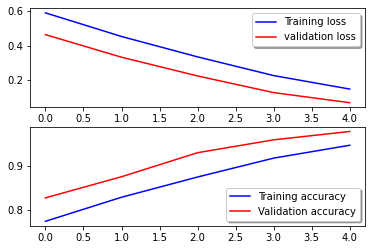

In [37]:

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history_LSTM_CNN .history['loss'], color='b', label="Training loss")
ax[0].plot(history_LSTM_CNN .history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history_LSTM_CNN.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_LSTM_CNN.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

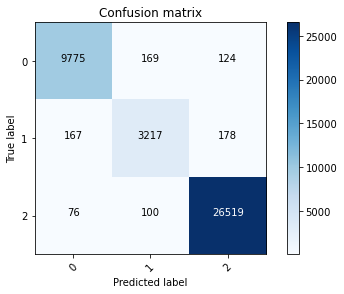

In [38]:
# Defining function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))